In [1]:
#!conda install pandas -y
#!conda install pyarrow -y

In [2]:
import os
import pandas as pd
import numpy as np

import cudf
import cupy
import nvtabular as nvt

In [3]:
DATA_FOLDER = "/workspace/yoochoose-data/"
FILENAME_PATTERN = 'yoochoose-clicks.dat'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

!ls $DATA_PATH

/workspace/yoochoose-data/yoochoose-clicks.dat


In [4]:
OUTPUT_FOLDER = "/workspace/yoochoose-data/preproc_sessions_by_day_ts"
!mkdir -p $OUTPUT_FOLDER

In [5]:
MINIMUM_SESSION_LENGTH = 2

### Loading data

In [6]:
#List of columns names to be used for CSV without the header line
HEADLESS_CSV_COLUMN_NAMES = ['session_id','timestamp', 'item_id', 'category']

In [7]:
interactions_df = cudf.read_csv(DATA_PATH, sep=',',
                    names=HEADLESS_CSV_COLUMN_NAMES,
                    parse_dates=['timestamp']
                   )

### Removing consecutive repeated interactions

In [8]:
print("Count with in-session repeated interactions: {}".format(len(interactions_df)))
# Sorts the dataframe by session and timestamp, to remove consective repetitions
interactions_df = interactions_df.sort_values(['session_id', 'timestamp'])
interactions_df['item_id_past'] = interactions_df['item_id'].shift(1)
interactions_df['session_id_past'] = interactions_df['session_id'].shift(1)
#Keeping only no consectutive repeated in session interactions
interactions_df = interactions_df[~((interactions_df['session_id'] == interactions_df['session_id_past']) & \
                 (interactions_df['item_id'] == interactions_df['item_id_past']))]
print("Count after removed in-session repeated interactions: {}".format(len(interactions_df)))

Count with in-session repeated interactions: 33003944
Count after removed in-session repeated interactions: 28971543


In [9]:
del(interactions_df['item_id_past'])
del(interactions_df['session_id_past'])

### Including the item first time seen feature (for recency calculation)

In [10]:
items_first_ts_df = interactions_df.groupby('item_id').agg({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'itemid_ts_first'})
items_first_ts_df.head()

,item_id,itemid_ts_first
0,214715625,2014-04-01 07:23:39.174
1,214754250,2014-04-13 18:29:11.989
2,214744050,2014-04-01 07:56:25.624
3,214754085,2014-04-14 17:52:41.453
4,214738445,2014-04-01 07:21:35.570


In [11]:
interactions_merged_df = interactions_df.merge(items_first_ts_df, on=['item_id'], how='left')

In [12]:
interactions_merged_df.head()

,session_id,timestamp,item_id,category,itemid_ts_first
0,2128,2014-04-06 16:16:26.313,214821279,0,2014-04-01 04:47:17.582
1,2128,2014-04-06 16:20:18.669,214820225,0,2014-04-01 04:17:47.600
2,2129,2014-04-01 14:08:05.139,214536320,0,2014-04-01 05:45:36.850
3,2129,2014-04-01 14:08:57.336,214835585,0,2014-04-01 05:15:24.284
4,2129,2014-04-01 14:09:06.160,214835760,0,2014-04-01 03:18:57.003


In [13]:
interactions_merged_df.shape

(28971543, 5)

In [14]:
# interactions_merged_df = interactions_merged_df.loc[:999999, :]

### Temporal features

In [15]:
# create time features
sessionTime = ['timestamp']

sessionTime_hour = (
    sessionTime >> 
    #nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='ms').dt.hour) >> 
    nvt.ops.LambdaOp(lambda col: col.dt.hour) >> 
    nvt.ops.Rename(postfix = '_hour')
)
sessionTime_weekday = (
    sessionTime >> 
    #nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='ms').dt.weekday) >> 
    nvt.ops.LambdaOp(lambda col: col.dt.weekday) >> 
    nvt.ops.Rename(postfix = '_wd')
)
sessionTime_day = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.day) >> 
    nvt.ops.Rename(postfix="_day")
)
sessionTime_month = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.month) >> 
    nvt.ops.Rename(postfix="_month")
)
sessionTime_year = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.year) >> 
    nvt.ops.Rename(postfix="_year")
)

sessionTime_timestamp = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: (col.astype(int) / 1e6).astype(int)) >> 
    nvt.ops.Rename(f = lambda col: "ts")
)

In [16]:
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

In [17]:
hour_sin = sessionTime_hour >> (lambda col: get_cycled_feature_value_sin(col, 24)) >> nvt.ops.Rename(postfix = '_sin')
hour_cos = sessionTime_hour >> (lambda col: get_cycled_feature_value_cos(col, 24)) >> nvt.ops.Rename(postfix = '_cos')
weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(postfix = '_sin')
weekday_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col+1, 7)) >> nvt.ops.Rename(postfix = '_cos')

In [18]:
cycled_features = hour_sin + hour_cos + weekday_sin + weekday_cos

In [19]:
cycled_features.columns

['timestamp_hour_sin',
 'timestamp_hour_cos',
 'timestamp_wd_sin',
 'timestamp_wd_cos']

In [20]:
# standar scale the cycled_features
#cycled_features_norm = cycled_features >> nvt.ops.Normalize() >> nvt.ops.Rename(postfix = '_norm')

In [21]:
# calculate item recency 
# create custom op
from nvtabular.ops import Operator

class ItemRecency(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            #col.loc[col == ""] = None
            item_first_timestamp = gdf['itemid_ts_first']
            delta_days = (col - item_first_timestamp).dt.days
            gdf[column + "_age_days"] = delta_days * (delta_days >=0)
        return gdf
            
    def output_column_names(self, columns):
        return [column + "_age_days" for column in columns]
            
    def dependencies(self):
        return ["itemid_ts_first"]

In [22]:
recency_features = ["timestamp"] >> ItemRecency() 
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(postfix = '_norm')

In [23]:
recency_features.columns, recency_features_norm.columns

(['timestamp_age_days'], ['timestamp_age_days_norm'])

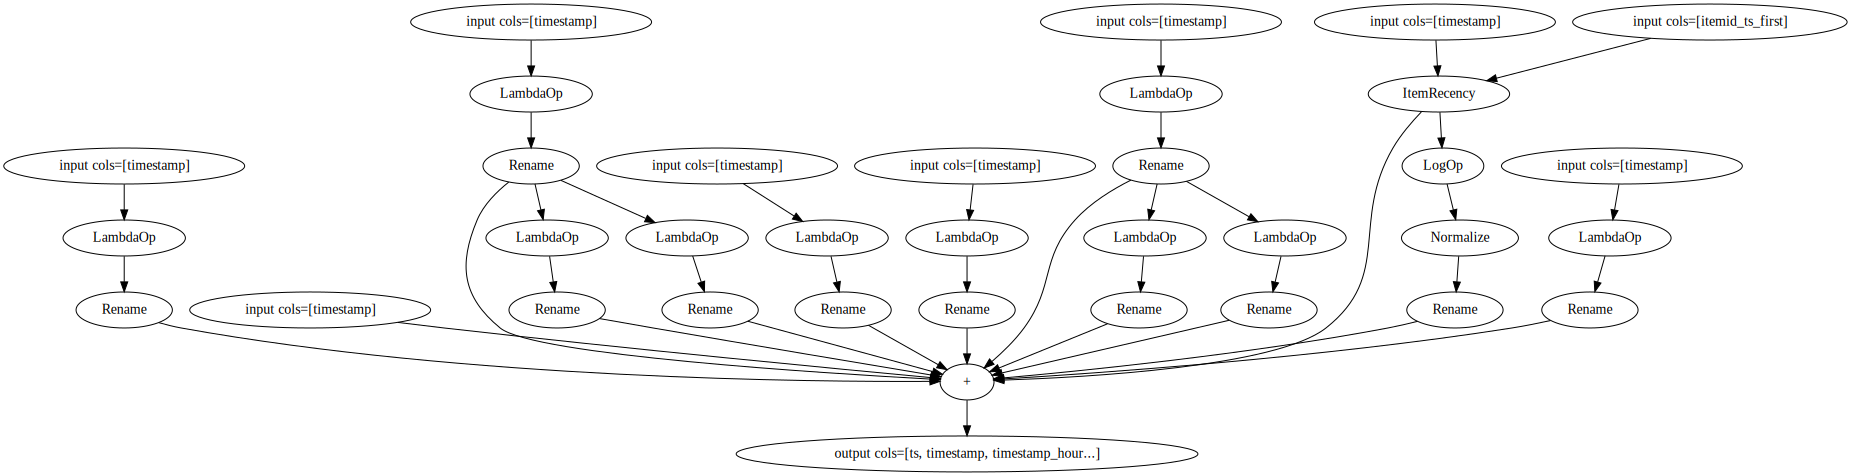

In [24]:
time_features = (
    sessionTime_timestamp +
    sessionTime + 
    sessionTime_hour +
    sessionTime_day + 
    sessionTime_month + 
    sessionTime_year +
    sessionTime_weekday +
    recency_features +
    recency_features_norm + 
    cycled_features
    #cycled_features_norm
)
time_features.graph

In [25]:
time_features.columns

['ts',
 'timestamp',
 'timestamp_hour',
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
 'timestamp_wd',
 'timestamp_age_days',
 'timestamp_age_days_norm',
 'timestamp_hour_sin',
 'timestamp_hour_cos',
 'timestamp_wd_sin',
 'timestamp_wd_cos']

### Categorify

In [26]:
categ_features = ['item_id', 'category'] >> nvt.ops.Categorify()

### Grouping interactions into sessions

In [27]:
# Define Groupby Workflow
groupby_features = categ_features + ['session_id']+ time_features >> nvt.ops.Groupby(
    groupby_cols=["session_id"], 
    sort_cols=["ts"],
    aggs={
        "item_id": ["list", "count"],
        "category": ["list"],        
        "ts": ["list", "first", "last"],
        "timestamp": ["first"],
        'timestamp_day': ["list"],
        'timestamp_hour': ["list"],
        'timestamp_month': ["list"],
        'timestamp_wd': ["list"],
        'timestamp_age_days': ["list"],
        'timestamp_age_days_norm': ["list"],
        'timestamp_hour_sin': ["list"],
        'timestamp_hour_sin_norm': ["list"],
        'timestamp_hour_cos': ["list"],
        'timestamp_hour_cos_norm': ["list"],
        'timestamp_wd_sin': ["list"],
        'timestamp_wd_sin_norm': ["list"],
        'timestamp_wd_cos': ["list"],
        'timestamp_wd_cos_norm': ["list"],        
        },
    name_sep="-")

In [28]:
groupby_features.columns

['session_id',
 'item_id-list',
 'timestamp_wd_cos-list',
 'ts-list',
 'ts-first',
 'timestamp-first',
 'timestamp_age_days-list',
 'ts-last',
 'timestamp_month-list',
 'category-list',
 'timestamp_hour-list',
 'timestamp_age_days_norm-list',
 'timestamp_day-list',
 'timestamp_hour_cos-list',
 'timestamp_wd-list',
 'timestamp_hour_sin-list',
 'timestamp_wd_sin-list',
 'item_id-count']

In [29]:
groupby_features_nonlist = [x for x in groupby_features.columns if '-list' not in x]
groupby_features_nonlist

['session_id', 'ts-first', 'timestamp-first', 'ts-last', 'item_id-count']

In [30]:
(groupby_features - groupby_features_nonlist).columns

['item_id-list',
 'timestamp_wd_cos-list',
 'ts-list',
 'timestamp_age_days-list',
 'timestamp_month-list',
 'category-list',
 'timestamp_hour-list',
 'timestamp_age_days_norm-list',
 'timestamp_day-list',
 'timestamp_hour_cos-list',
 'timestamp_wd-list',
 'timestamp_hour_sin-list',
 'timestamp_wd_sin-list']

In [31]:
groupby_features_trim = ((groupby_features - groupby_features_nonlist)) >> nvt.ops.ListSlice(0,20) >> nvt.ops.Rename(postfix = '_trim')

In [32]:
groupby_features_trim.columns

['item_id-list_trim',
 'timestamp_wd_cos-list_trim',
 'ts-list_trim',
 'timestamp_age_days-list_trim',
 'timestamp_month-list_trim',
 'category-list_trim',
 'timestamp_hour-list_trim',
 'timestamp_age_days_norm-list_trim',
 'timestamp_day-list_trim',
 'timestamp_hour_cos-list_trim',
 'timestamp_wd-list_trim',
 'timestamp_hour_sin-list_trim',
 'timestamp_wd_sin-list_trim']

In [33]:
# calculate session day index based on 'timestamp-first' column
remaining_columns = [x for x in groupby_features.columns if x!= 'timestamp-first']
day_index = ( (groupby_features - remaining_columns)  >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(f = lambda col: "day_index")
)

In [34]:
day_idx_padded = day_index >> (lambda col: col.astype(str).str.pad(4,fillchar='0')) >> nvt.ops.Rename(f = lambda col: "day_idx_padded")

In [35]:
rename_cols = {"item_id-count": "session_size"} 
groupby_features = groupby_features >> nvt.ops.Rename(lambda col: rename_cols.get(col, col))
#groupby_features_nonlist = groupby_features_nonlist >> nvt.ops.Rename(lambda col: rename_cols.get(col, col))

In [37]:
filtered_sessions = (groupby_features + groupby_features_trim + day_index + day_idx_padded) >> \
                     nvt.ops.Filter(f=lambda df: df["session_size"] >= MINIMUM_SESSION_LENGTH)

In [38]:
workflow = nvt.Workflow(filtered_sessions)

In [39]:
dataset = nvt.Dataset(interactions_merged_df, cpu=False)
workflow.fit(dataset)
new_gdf = workflow.transform(dataset).to_ddf().compute()
len(new_gdf)

6756575

In [40]:
categ_features.op.get_embedding_sizes(categ_features.columns)
#{'category': (336, 42), 'item_id': (52740, 512)}

{'category': (336, 42), 'item_id': (52740, 512)}

In [41]:
new_gdf.head(10)

,session_id,item_id-list,timestamp_wd_cos-list,ts-list,ts-first,timestamp-first,timestamp_age_days-list,ts-last,timestamp_month-list,category-list,...,category-list_trim,timestamp_hour-list_trim,timestamp_age_days_norm-list_trim,timestamp_day-list_trim,timestamp_hour_cos-list_trim,timestamp_wd-list_trim,timestamp_hour_sin-list_trim,timestamp_wd_sin-list_trim,day_index,day_idx_padded
0,1,"[2053, 2055, 9877]","[0.6234891, 0.6234891, 0.6234891]","[1396868049868, 1396868086998, 1396868220305]",1396868049868,2014-04-07 10:54:09.868,"[6, 5, 5]",1396868220305,"[4, 4, 4]","[1, 1, 1]",...,"[1, 1, 1]","[10, 10, 10]","[-1.257142, -1.3886861, -1.3886861]","[7, 7, 7]","[-0.8660256, -0.8660256, -0.8660256]","[0, 0, 0]","[0.49999964, 0.49999964, 0.49999964]","[0.7818321, 0.7818321, 0.7818321]",7,0007
1,2,"[19449, 40789, 32517, 32523, 4854]","[0.6234891, 0.6234891, 0.6234891, 0.6234891, 0...","[1396878997614, 1396879117446, 1396879190710, ...",1396878997614,2014-04-07 13:56:37.614,"[6, 1, 1, 1, 6]",1396879356889,"[4, 4, 4, 4, 4]","[1, 1, 1, 1, 1]",...,"[1, 1, 1, 1, 1]","[13, 13, 13, 14, 14]","[-1.257142, -2.326184, -2.326184, -2.326184, -...","[7, 7, 7, 7, 7]","[-0.96592575, -0.96592575, -0.96592575, -0.866...","[0, 0, 0, 0, 0]","[-0.2588193, -0.2588193, -0.2588193, -0.500000...","[0.7818321, 0.7818321, 0.7818321, 0.7818321, 0...",7,0007
2,3,"[28990, 35311, 43179]","[-0.90096927, -0.90096927, -0.90096927]","[1396444666940, 1396445162515, 1396445412318]",1396444666940,2014-04-02 13:17:46.940,"[1, 1, 1]",1396445412318,"[4, 4, 4]","[1, 1, 1]",...,"[1, 1, 1]","[13, 13, 13]","[-2.326184, -2.326184, -2.326184]","[2, 2, 2]","[-0.96592575, -0.96592575, -0.96592575]","[2, 2, 2]","[-0.2588193, -0.2588193, -0.2588193]","[0.43388295, 0.43388295, 0.43388295]",2,0002
3,4,"[44326, 26362]","[0.6234891, 0.6234891]","[1396872550948, 1396873585416]",1396872550948,2014-04-07 12:09:10.948,"[6, 6]",1396873585416,"[4, 4]","[1, 1]",...,"[1, 1]","[12, 12]","[-1.257142, -1.257142]","[7, 7]","[-1.0, -1.0]","[0, 0]","[-5.6425995e-07, -5.6425995e-07]","[0.7818321, 0.7818321]",7,0007
4,6,"[25633, 41161]","[1.0, 1.0]","[1396803500848, 1396803746976]",1396803500848,2014-04-06 16:58:20.848,"[5, 5]",1396803746976,"[4, 4]","[1, 1]",...,"[1, 1]","[16, 17]","[-1.3886861, -1.3886861]","[6, 6]","[-0.4999995, -0.25881854]","[6, 6]","[-0.8660257, -0.965926]","[1.1285199e-06, 1.1285199e-06]",6,0006
5,7,"[41233, 41185]","[-0.90096927, -0.90096927]","[1396420733104, 1396420745854]",1396420733104,2014-04-02 06:38:53.104,"[1, 1]",1396420745854,"[4, 4]","[1, 1]",...,"[1, 1]","[6, 6]","[-2.326184, -2.326184]","[2, 2]","[-2.8212997e-07, -2.8212997e-07]","[2, 2]","[1.0, 1.0]","[0.43388295, 0.43388295]",2,0002
6,11,"[39928, 39967, 29055, 7959, 26356, 29168, 3063...","[-0.90096843, -0.90096843, -0.90096843, -0.900...","[1396521875672, 1396521929873, 1396522402572, ...",1396521875672,2014-04-03 10:44:35.672,"[2, 2, 2, 2, 1, 2, 2, 0, 2]",1396522659433,"[4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10, 10, 10]","[-1.9801813, -1.9801813, -1.9801813, -1.980181...","[3, 3, 3, 3, 3, 3, 3, 3, 3]","[-0.8660256, -0.8660256, -0.8660256, -0.866025...","[3, 3, 3, 3, 3, 3, 3, 3, 3]","[0.49999964, 0.49999964, 0.49999964, 0.4999996...","[-0.43388462, -0.43388462, -0.43388462, -0.433...",3,0003
7,13,"[44325, 22424, 44325]","[1.0, 1.0, 1.0]","[1396795813638, 1396795974363, 1396795998268]",1396795813638,2014-04-06 14:50:13.638,"[5, 5, 5]",1396795998268,"[4, 4, 4]","[1, 1, 1]",...,"[1, 1, 1]","[14, 14, 14]","[-1.3886861, -1.3886861, -1.3886861]","[6, 6, 6]","[-0.8660252, -0.8660252, -0.8660252]","[6, 6, 6]","[-0.50000036, -0.50000036, -0.50000036]","[1.1285199e-06, 1.1285199e-06, 1.1285199e-06]",6,0006
8,14,"[9918, 11196, 9918]","[-0.22252177, -0.22252177, -0.22252177]","[1396346941361, 1396347074773, 1396347156481]",1396346941361,2014-04-01 10:09:01.362,"[0, 0, 0]",1396347156481,"[4, 4, 4]","[1, 1, 1]",...,"[1, 1, 1]","[10, 10, 10]","[-2.91

In [42]:
SELECTED_COLS = ['session_id', 'day_idx_padded', 'session_size', 'item_id-list_trim', 'category-list_trim', 'ts-first', 'ts-first', 'ts-last',  'ts-list_trim', 
'timestamp_hour_cos-list_trim', 'timestamp_hour_sin-list_trim', 'timestamp_wd_sin-list_trim', 'timestamp_wd_cos-list_trim',
'timestamp_age_days-list_trim', 'timestamp_age_days_norm-list_trim']
sessions_gdf = new_gdf[SELECTED_COLS]
sessions_gdf.head()

,session_id,day_idx_padded,session_size,item_id-list_trim,category-list_trim,ts-first,ts-last,ts-list_trim,timestamp_hour_cos-list_trim,timestamp_hour_sin-list_trim,timestamp_wd_sin-list_trim,timestamp_wd_cos-list_trim,timestamp_age_days-list_trim,timestamp_age_days_norm-list_trim
0,1,0007,3,"[2053, 2055, 9877]","[1, 1, 1]",1396868049868,1396868220305,"[1396868049868, 1396868086998, 1396868220305]","[-0.8660256, -0.8660256, -0.8660256]","[0.49999964, 0.49999964, 0.49999964]","[0.7818321, 0.7818321, 0.7818321]","[0.6234891, 0.6234891, 0.6234891]","[6, 5, 5]","[-1.257142, -1.3886861, -1.3886861]"
1,2,0007,5,"[19449, 40789, 32517, 32523, 4854]","[1, 1, 1, 1, 1]",1396878997614,1396879356889,"[1396878997614, 1396879117446, 1396879190710, ...","[-0.96592575, -0.96592575, -0.96592575, -0.866...","[-0.2588193, -0.2588193, -0.2588193, -0.500000...","[0.7818321, 0.7818321, 0.7818321, 0.7818321, 0...","[0.6234891, 0.6234891, 0.6234891, 0.6234891, 0...","[6, 1, 1, 1, 6]","[-1.257142, -2.326184, -2.326184, -2.326184, -..."
2,3,0002,3,"[28990, 35311, 43179]","[1, 1, 1]",1396444666940,1396445412318,"[1396444666940, 1396445162515, 1396445412318]","[-0.96592575, -0.96592575, -0.96592575]","[-0.2588193, -0.2588193, -0.2588193]","[0.43388295, 0.43388295, 0.43388295]","[-0.90096927, -0.90096927, -0.90096927]","[1, 1, 1]","[-2.326184, -2.326184, -2.326184]"
3,4,0007,2,"[44326, 26362]","[1, 1]",1396872550948,1396873585416,"[1396872550948, 1396873585416]","[-1.0, -1.0]","[-5.6425995e-07, -5.6425995e-07]","[0.7818321, 0.7818321]","[0.6234891, 0.6234891]","[6, 6]","[-1.257142, -1.257142]"
4,6,0006,2,"[25633, 41161]","[1, 1]",1396803500848,1396803746976,"[1396803500848, 1396803746976]","[-0.4999995, -0.25881854]","[-0.8660257, -0.965926]","[1.1285199e-06, 1.1285199e-06]","[1.0, 1.0]","[5, 5]","[-1.3886861, -1.3886861]"


In [43]:
#sessions_pdf = sessions_gdf.to_pandas()
# cols = ['item_id-list_trim', 'category-list_trim', 'ts-list_trim', 'timestamp_hour_cos-list_trim', 'timestamp_hour_sin-list_trim', 'timestamp_wd_sin-list_trim', 'timestamp_wd_cos-list_trim',
# 'timestamp_age_days-list_trim', 'timestamp_age_days_norm-list_trim']

# for col in cols:
#     print(sessions_pdf[col].apply(len).max())

### Checking results

In [43]:
sessions_gdf['day_idx_padded'].min(), sessions_gdf['day_idx_padded'].max()

('0001', '0182')

In [44]:
sessions_gdf.groupby('day_idx_padded').size().sort_index()

0001    44017
0002    42358
0003    45074
0004    33102
0005    34515
        ...  
0178    35605
0179    25555
0180    21023
0181    10766
0182    13297
Length: 182, dtype: int32

In [45]:
sessions_gdf['session_size'].describe()

count    6.756575e+06
mean     3.918907e+00
std      3.794900e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      2.000000e+02
Name: session_size, dtype: float64

In [46]:
sessions_gdf.groupby('session_size').size().sort_index()[:30]

session_size
2     2945317
3     1463175
4      785869
5      473054
6      299592
7      200109
8      137758
9       98787
10      72002
11      53589
12      41379
13      32072
14      25125
15      19699
16      16087
17      13117
18      10714
19       8932
20       7536
21       6329
22       5535
23       4735
24       3832
25       3444
26       2933
27       2551
28       2356
29       1959
30       1762
31       1573
dtype: int32

### Exporting session by day 

#### Saving using hive-partitioned data

In [47]:
PARTITION_COL = 'day_idx_padded'

In [48]:
# Convert to a Dataset and write out hive-partitioned data to disk
nvt_output_path_tmp ='./output_nvt_tmp/'
nvt.Dataset(sessions_gdf).to_parquet(nvt_output_path_tmp, partition_on=[PARTITION_COL])

In [50]:
!ls $nvt_output_path_tmp/

 _file_list.txt        'day_idx_padded=0060'  'day_idx_padded=0122'
 _metadata	       'day_idx_padded=0061'  'day_idx_padded=0123'
 _metadata.json        'day_idx_padded=0062'  'day_idx_padded=0124'
'day_idx_padded=0001'  'day_idx_padded=0063'  'day_idx_padded=0125'
'day_idx_padded=0002'  'day_idx_padded=0064'  'day_idx_padded=0126'
'day_idx_padded=0003'  'day_idx_padded=0065'  'day_idx_padded=0127'
'day_idx_padded=0004'  'day_idx_padded=0066'  'day_idx_padded=0128'
'day_idx_padded=0005'  'day_idx_padded=0067'  'day_idx_padded=0129'
'day_idx_padded=0006'  'day_idx_padded=0068'  'day_idx_padded=0130'
'day_idx_padded=0007'  'day_idx_padded=0069'  'day_idx_padded=0131'
'day_idx_padded=0008'  'day_idx_padded=0070'  'day_idx_padded=0132'
'day_idx_padded=0009'  'day_idx_padded=0071'  'day_idx_padded=0133'
'day_idx_padded=0010'  'day_idx_padded=0072'  'day_idx_padded=0134'
'day_idx_padded=0011'  'day_idx_padded=0073'  'day_idx_padded=0135'
'day_idx_padded=0012'  'day_idx_padded=0074'  'day_id

In [49]:
# Check one file
day_1 = cudf.read_parquet(os.path.join(nvt_output_path_tmp, 'day_idx_padded=0001/part.0.parquet'))
day_1

,session_id,session_size,item_id-list_trim,category-list_trim,ts-first,ts-last,ts-list_trim,timestamp_hour_cos-list_trim,timestamp_hour_sin-list_trim,timestamp_wd_sin-list_trim,timestamp_wd_cos-list_trim,timestamp_age_days-list_trim,timestamp_age_days_norm-list_trim
0,14,3,"[9918, 11196, 9918]","[1, 1, 1]",1396346941361,1396347156481,"[1396346941361, 1396347074773, 1396347156481]","[-0.8660256, -0.8660256, -0.8660256]","[0.49999964, 0.49999964, 0.49999964]","[0.9749277, 0.9749277, 0.9749277]","[-0.22252177, -0.22252177, -0.22252177]","[0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793]"
1,19,2,"[7832, 13821]","[1, 1]",1396385532357,1396385693606,"[1396385532357, 1396385693606]","[0.5000007, 0.5000007]","[-0.866025, -0.866025]","[0.9749277, 0.9749277]","[-0.22252177, -0.22252177]","[0, 0]","[-2.9176793, -2.9176793]"
2,39,2,"[22514, 21519]","[1, 1]",1396387260460,1396387304551,"[1396387260460, 1396387304551]","[0.707107, 0.707107]","[-0.70710653, -0.70710653]","[0.9749277, 0.9749277]","[-0.22252177, -0.22252177]","[0, 0]","[-2.9176793, -2.9176793]"
3,48,4,"[24302, 24301, 2505, 20625]","[1, 1, 1, 1]",1396354328080,1396354610572,"[1396354328080, 1396354365019, 1396354378585, ...","[-1.0, -1.0, -1.0, -1.0]","[-5.6425995e-07, -5.6425995e-07, -5.6425995e-0...","[0.9749277, 0.9749277, 0.9749277, 0.9749277]","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.9176793]"
4,51,5,"[3861, 39358, 45409, 44069, 44140]","[1, 1, 1, 1, 1]",1396375531791,1396375780735,"[1396375531791, 1396375604207, 1396375650896, ...","[4.8876205e-07, 4.8876205e-07, 4.8876205e-07, ...","[-1.0, -1.0, -1.0, -1.0, -1.0]","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44012,494917,6,"[29024, 28987, 29024, 28986, 29024, 28987]","[1, 1, 1, 1, 1, 1]",1396380350288,1396380590364,"[1396380350288, 1396380380891, 1396380517351, ...","[0.25881946, 0.25881946, 0.25881946, 0.2588194...","[-0.9659257, -0.9659257, -0.9659257, -0.965925...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
44013,494918,4,"[45637, 96, 2704, 10677]","[1, 1, 1, 1]",1396355997736,1396356338817,"[1396355997736, 1396356094192, 1396356175574, ...","[-1.0, -1.0, -1.0, -1.0]","[-5.6425995e-07, -5.6425995e-07, -5.6425995e-0...","[0.9749277, 0.9749277, 0.9749277, 0.9749277]","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.9176793]"
44014,494921,2,"[39906, 39402]","[1, 1]",1396374640327,1396374653449,"[1396374640327, 1396374653449]","[-0.25881854, -0.25881854]","[-0.965926, -0.965926]","[0.9749277, 0.9749277]","[-0.22252177, -0.22252177]","[0, 0]","[-2.9176793, -2.9176793]"
44015,494922,2,"[28990, 28988]","[1, 1]",1396347144305,1396347344812,"[1396347144305, 1396347344812]","[-0.8660256, -0.8660256]","[0.49999964, 0.49999964]","[0.9749277, 0.9749277]","[-0.22252177, -0.22252177]","[0, 0]","[-2.9176793, -2.9176793]"


In [52]:
day_1.columns

Index(['session_id', 'session_size', 'item_id-list_trim', 'category-list_trim',
       'ts-first', 'ts-last', 'ts-list_trim', 'timestamp_hour_cos-list_trim',
       'timestamp_hour_sin-list_trim', 'timestamp_wd_sin-list_trim',
       'timestamp_wd_cos-list_trim', 'timestamp_age_days-list_trim',
       'timestamp_age_days_norm-list_trim'],
      dtype='object')

#### Converting to the HF4Rec dir structure and splitting dataset

In [56]:
rename_cols = ['session_id', 'session_size', 'item_id-list', 'category-list', 'ts-first', 'ts-last',  'ts-list', 
'timestamp_hour_cos-list', 'timestamp_hour_sin-list', 'timestamp_wd_sin-list', 'timestamp_wd_cos-list', 'timestamp_age_days-list', 'timestamp_age_days_norm-list']

In [57]:
days_folders = [f for f in sorted(os.listdir(nvt_output_path_tmp)) if f.startswith(PARTITION_COL)]
for day_folder in days_folders:
    df = cudf.read_parquet(os.path.join(nvt_output_path_tmp, day_folder))
    df = df.sort_values('ts-first')
    print(len(df))
    #print(df.columns)
    df.columns = rename_cols
    out_folder = os.path.join(OUTPUT_FOLDER, day_folder.replace('day_idx_padded=', ''))
    os.makedirs(out_folder, exist_ok=True)
    df.to_parquet(os.path.join(out_folder, 'train.parquet'))
    
    random_values = cupy.random.rand(len(df))
    
    #Extracts 10% for valid and test set. Those sessions are also in the train set, but as evaluation
    #happens only for the subsequent day of training, that is not an issue, and we can keep the train set larger.
    valid_set = df[random_values <= 0.10]
    valid_set.to_parquet(os.path.join(out_folder, 'valid.parquet'))
    
    test_set = df[random_values >= 0.90]
    test_set.to_parquet(os.path.join(out_folder, 'test.parquet'))

44017
42358
45074
33102
34515
61399
48062
34726
39439
36216
24697
28752
58691
54321
38695
31093
21344
29839
20507
33190
47846
42309
40325
38964
28248
32894
67929
53832
41259
33148
34525
32369
30743
58694
30669
1305
41639
42447
30069
36005
67958
66624
41047
40048
37888
26457
28067
58177
52813
40518
37740
34592
29415
29054
54092
56778
1684
39018
35188
30125
32546
67557
66231
1591
44374
41167
27114
25412
44538
51728
53538
49282
43286
30025
31383
55148
45088
1459
30213
26395
24843
27194
55473
45862
1358
35447
30289
23502
26631
56166
44429
1194
31785
24836
16750
22927
42728
41468
1334
38476
37072
26639
28090
47511
42925
1436
35653
35334
25042
24527
51154
59165
1510
38300
39108
27602
26675
53596
52763
8694
35696
31012
22940
24113
49009
50884
9885
35676
37699
28091
37425
77580
71852
12141
48246
47395
35597
34906
68722
71651
12953
52105
52598
37510
39111
65721
64929
10293
46057
42088
29747
32011
70483
65988
9104
10196
39880
29644
17287
76214
69830
10870
49303
13091
37497
43318
73382
65710
9185

In [58]:
!ls -la $OUTPUT_FOLDER

total 92
drwxr-xr-x 184 root root  601944086 May 13 13:54 .
drwxr-xr-x   4 root root 3390209324 May 13 13:52 ..
drwxr-xr-x   2 root root    3345145 May 13 13:52 0001
drwxr-xr-x   2 root root    3200431 May 13 13:52 0002
drwxr-xr-x   2 root root    3461213 May 13 13:52 0003
drwxr-xr-x   2 root root    2608600 May 13 13:52 0004
drwxr-xr-x   2 root root    2791794 May 13 13:52 0005
drwxr-xr-x   2 root root    4941651 May 13 13:52 0006
drwxr-xr-x   2 root root    3786545 May 13 13:52 0007
drwxr-xr-x   2 root root    2876473 May 13 13:52 0008
drwxr-xr-x   2 root root    3247476 May 13 13:53 0009
drwxr-xr-x   2 root root    2961729 May 13 13:53 0010
drwxr-xr-x   2 root root    2068417 May 13 13:53 0011
drwxr-xr-x   2 root root    2479962 May 13 13:53 0012
drwxr-xr-x   2 root root    5056723 May 13 13:53 0013
drwxr-xr-x   2 root root    4455721 May 13 13:53 0014
drwxr-xr-x   2 root root    3192080 May 13 13:53 0015
drwxr-xr-x   2 root root    2569171 May 13 13:53 0016
drwxr-xr-x   2 root root

In [59]:
!ls -la $OUTPUT_FOLDER/0001

total 3269
drwxr-xr-x   2 root root   3345145 May 13 13:52 .
drwxr-xr-x 184 root root 601944086 May 13 13:54 ..
-rw-r--r--   1 root root    276193 May 13 13:52 test.parquet
-rw-r--r--   1 root root   2775165 May 13 13:52 train.parquet
-rw-r--r--   1 root root    293787 May 13 13:52 valid.parquet


In [60]:
df = cudf.read_parquet(os.path.join(OUTPUT_FOLDER, '0001/train.parquet'))
df

,session_id,session_size,item_id-list,category-list,ts-first,ts-last,ts-list,timestamp_hour_cos-list,timestamp_hour_sin-list,timestamp_wd_sin-list,timestamp_wd_cos-list,timestamp_age_days-list,timestamp_age_days_norm-list
31230,351646,2,"[29023, 28986]","[1, 1]",1396321200124,1396321393688,"[1396321200124, 1396321393688]","[0.70710653, 0.70710653]","[0.707107, 0.707107]","[0.9749277, 0.9749277]","[-0.22252177, -0.22252177]","[0, 0]","[-2.9176793, -2.9176793]"
34633,389654,5,"[41181, 11387, 41181, 41218, 41181]","[1, 1, 1, 1, 1]",1396321200567,1396321799204,"[1396321200567, 1396321248736, 1396321356728, ...","[0.70710653, 0.70710653, 0.70710653, 0.7071065...","[0.707107, 0.707107, 0.707107, 0.707107, 0.707...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
18660,210798,12,"[10486, 25242, 22800, 10483, 10484, 713, 10484...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1396321213070,1396322044241,"[1396321213070, 1396321268992, 1396321299135, ...","[0.70710653, 0.70710653, 0.70710653, 0.7071065...","[0.707107, 0.707107, 0.707107, 0.707107, 0.707...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
33364,375257,11,"[16141, 10670, 18392, 18391, 18755, 18391, 187...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1396321213768,1396321787368,"[1396321213768, 1396321263865, 1396321416094, ...","[0.70710653, 0.70710653, 0.70710653, 0.7071065...","[0.707107, 0.707107, 0.707107, 0.707107, 0.707...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
15154,171168,2,"[12239, 39623]","[1, 1]",1396321220129,1396321232609,"[1396321220129, 1396321232609]","[0.70710653, 0.70710653]","[0.707107, 0.707107]","[0.9749277, 0.9749277]","[-0.22252177, -0.22252177]","[0, 0]","[-2.9176793, -2.9176793]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27369,308522,3,"[6583, 39608, 25291]","[1, 1, 1]",1396407506423,1396407506441,"[1396407506423, 1396407506440, 1396407506441]","[0.86602527, 0.86602527, 0.86602527]","[0.50000024, 0.50000024, 0.50000024]","[0.43388295, 0.43388295, 0.43388295]","[-0.90096927, -0.90096927, -0.90096927]","[0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793]"
34555,388557,9,"[31195, 39395, 871, 1810, 18138, 10044, 7413, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1]",1396407510869,1396409006525,"[1396407510869, 1396407762953, 1396407800168, ...","[0.86602527, 0.70710653, 0.70710653, 0.7071065...","[0.50000024, 0.707107, 0.707107, 0.707107, 0.7...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[-0.90096927, -0.90096927, -0.90096927, -0.900...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
11772,133451,5,"[39906, 11326, 39397, 41262, 39371]","[1, 1, 1, 1, 1]",1396407530937,1396408153528,"[1396407530937, 1396407691937, 1396407972549, ...","[0.86602527, 0.70710653, 0.70710653, 0.7071065...","[0.50000024, 0.707107, 0.707107, 0.707107, 0.7...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[-0.90096927, -0.90096927, -0.90096927, -0.900...","[0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."
8473,94974,9,"[29314, 9030, 29314, 27563, 39409, 26379, 2979...","[1, 1, 1, 1, 1, 1, 1, 1, 1]",1396407543201,1396407776287,"[1396407543201, 1396407544560, 1396407592124, ...","[0.86602527, 0.86602527, 0.86602527, 0.7071065...","[0.50000024, 0.50000024, 0.50000024, 0.707107,...","[0.43388295, 0.43388295, 0.43388295, 0.4338829...","[-0.90096927, -0.90096927, -0.90096927, -0.900...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[-2.9176793, -2.9176793, -2.9176793, -2.917679..."


In [63]:
pdf = df.to_pandas()
cols = ['item_id-list', 'category-list', 'ts-list', 'timestamp_hour_cos-list', 'timestamp_hour_sin-list', 'timestamp_wd_sin-list', 'timestamp_wd_cos-list',
'timestamp_age_days-list', 'timestamp_age_days_norm-list']

for col in cols:
    print(pdf[col].apply(len).describe())

count    44017.000000
mean         3.833064
std          2.938642
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         20.000000
Name: item_id-list, dtype: float64
count    44017.000000
mean         3.833064
std          2.938642
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         20.000000
Name: category-list, dtype: float64
count    44017.000000
mean         3.833064
std          2.938642
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         20.000000
Name: ts-list, dtype: float64
count    44017.000000
mean         3.833064
std          2.938642
min          2.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         20.000000
Name: timestamp_hour_cos-list, dtype: float64
count    44017.000000
mean         3.833064
std          2.938642
min          2.000000
25%          2.000000
50%          3.000000
75%          4.00